In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_dir = "/content/drive/MyDrive/Machine Learning Project/Dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [ ]:
img_size = (64, 64)
batch_size = 32
epochs = 10

In [ ]:
def load_images(data_dir, img_size):
    images = []
    labels = []
    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
images, labels = load_images(data_dir, img_size)
images = images / 255.0
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

In [ ]:
X_flattened = images.reshape(images.shape[0], -1)
X_train_flat, X_test_flat, y_train_enc, y_test_enc = train_test_split(X_flattened, labels_encoded, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_flat, y_train_enc)
svm_preds = svm_model.predict(X_test_flat)
print("SVM Classification Report:")
print(classification_report(y_test_enc, svm_preds, target_names=label_encoder.classes_))

SVM Classification Report:
              precision    recall  f1-score   support

         Bus       0.50      0.54      0.52        26
         Car       0.47      0.39      0.42        18
       Truck       0.35      0.50      0.41        18
  motorcycle       0.45      0.28      0.34        18

    accuracy                           0.44        80
   macro avg       0.44      0.43      0.42        80
weighted avg       0.45      0.44      0.43        80



In [ ]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,668 (6.20 MB)

 Trainable params: 1,625,668 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

In [ ]:
history = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.2647 - loss: 1.5532 - val_accuracy: 0.2750 - val_loss: 1.3708
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.3016 - loss: 1.3793 - val_accuracy: 0.3375 - val_loss: 1.3659
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.3861 - loss: 1.3467 - val_accuracy: 0.5125 - val_loss: 1.2814
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.4115 - loss: 1.2836 - val_accuracy: 0.4375 - val_loss: 1.2511
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - accuracy: 0.4601 - loss: 1.2012 - val_accuracy: 0.4375 - val_loss: 1.1975
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.4771 - loss: 1.1844 - val_accuracy: 0.5000 - val_loss: 1.1821
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5182 - loss: 1.0967 - val_accuracy: 0.5375 - val_loss: 1.1009
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.5279 - loss: 1.1098 - val_accuracy: 0.5750 - val_

In [ ]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"CNN Test Accuracy: {cnn_accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6562 - loss: 1.0005
CNN Test Accuracy: 62.50%


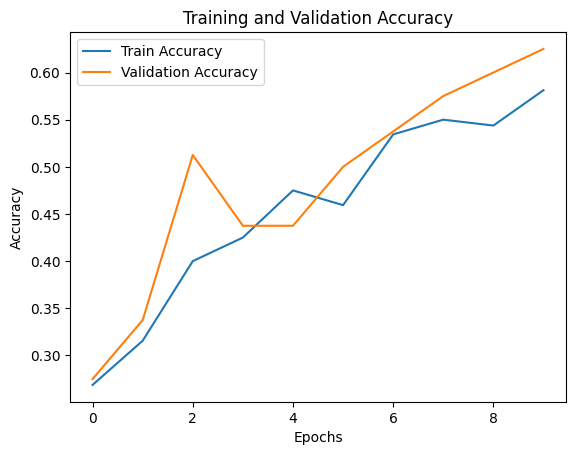

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
cnn_preds = cnn_model.predict(X_test)
cnn_preds_classes = np.argmax(cnn_preds, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print("CNN Classification Report:")
print(classification_report(y_test_classes, cnn_preds_classes, target_names=label_encoder.classes_))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
CNN Classification Report:
              precision    recall  f1-score   support

         Bus       0.71      0.58      0.64        26
         Car       0.52      0.67      0.59        18
       Truck       0.70      0.39      0.50        18
  motorcycle       0.62      0.89      0.73        18

    accuracy                           0.62        80
   macro avg       0.64      0.63      0.61        80
weighted avg       0.65      0.62      0.62        80



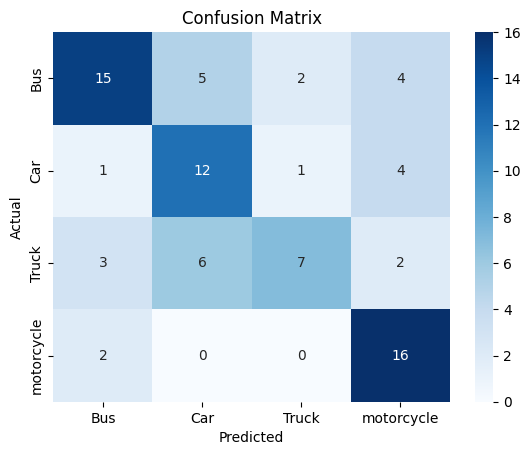

In [ ]:
conf_matrix = confusion_matrix(y_test_classes, cnn_preds_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()